In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
import warnings


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


np.random.seed(42)
tf.random.set_seed(42)


warnings.filterwarnings("ignore")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
file_name = 'Nat_Gas.csv'
df = pd.read_csv(file_name)
print("Data loaded successfully.")
print(df.head())

Data loaded successfully.
      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df['Prices'] = pd.to_numeric(df['Prices'])
df.set_index('Dates', inplace=True)
df.sort_index(inplace=True)

print("\nData preprocessed successfully.")
print(df.head())


Data preprocessed successfully.
            Prices
Dates             
2020-10-31    10.1
2020-11-30    10.3
2020-12-31    11.0
2021-01-31    10.9
2021-02-28    10.9


In [4]:
price_values = df['Prices'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_values)
print("\nData scaled successfully.")


Data scaled successfully.


In [5]:
def create_dataset(dataset, look_back=1):
    """Converts an array of values into a dataset of X and y."""
    X, y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)


look_back = 12
X, y = create_dataset(scaled_data, look_back)

In [6]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"\nData sequenced with look_back={look_back}.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Data sequenced with look_back=12.
Shape of X: (36, 12, 1)
Shape of y: (36,)


In [7]:
model = Sequential()
model.add(LSTM(
    units=50,
    input_shape=(look_back, 1)
))
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
model.fit(X, y, epochs=100, batch_size=1, verbose=0)

In [11]:


print("\nGenerating 12-month forecast...")


current_batch = scaled_data[-look_back:].reshape((1, look_back, 1))

forecast_scaled = []
forecast_steps = 12

for i in range(forecast_steps):

    pred = model.predict(current_batch, verbose=0)


    forecast_scaled.append(pred[0][0])



    new_pred = pred.reshape(1, 1, 1)


    current_batch = np.append(current_batch[:, 1:, :], new_pred, axis=1)


Generating 12-month forecast...


In [12]:
forecast_prices = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))


last_date = df.index[-1]
forecast_index = pd.date_range(
    start=last_date + pd.offsets.MonthEnd(1),
    periods=forecast_steps,
    freq='ME'
)

forecast_series = pd.Series(forecast_prices.flatten(), index=forecast_index)

print("\nOne-Year Price Extrapolation (Forecast):")
print(forecast_series)


One-Year Price Extrapolation (Forecast):
2024-10-31    12.121926
2024-11-30    12.462883
2024-12-31    12.745512
2025-01-31    12.867145
2025-02-28    12.848634
2025-03-31    12.664248
2025-04-30    12.279441
2025-05-31    11.944062
2025-06-30    11.782072
2025-07-31    11.733881
2025-08-31    11.811341
2025-09-30    12.024329
Freq: ME, dtype: float32



Saved continuous forecast plot to 'price_forecast_continuous_lstm.png'


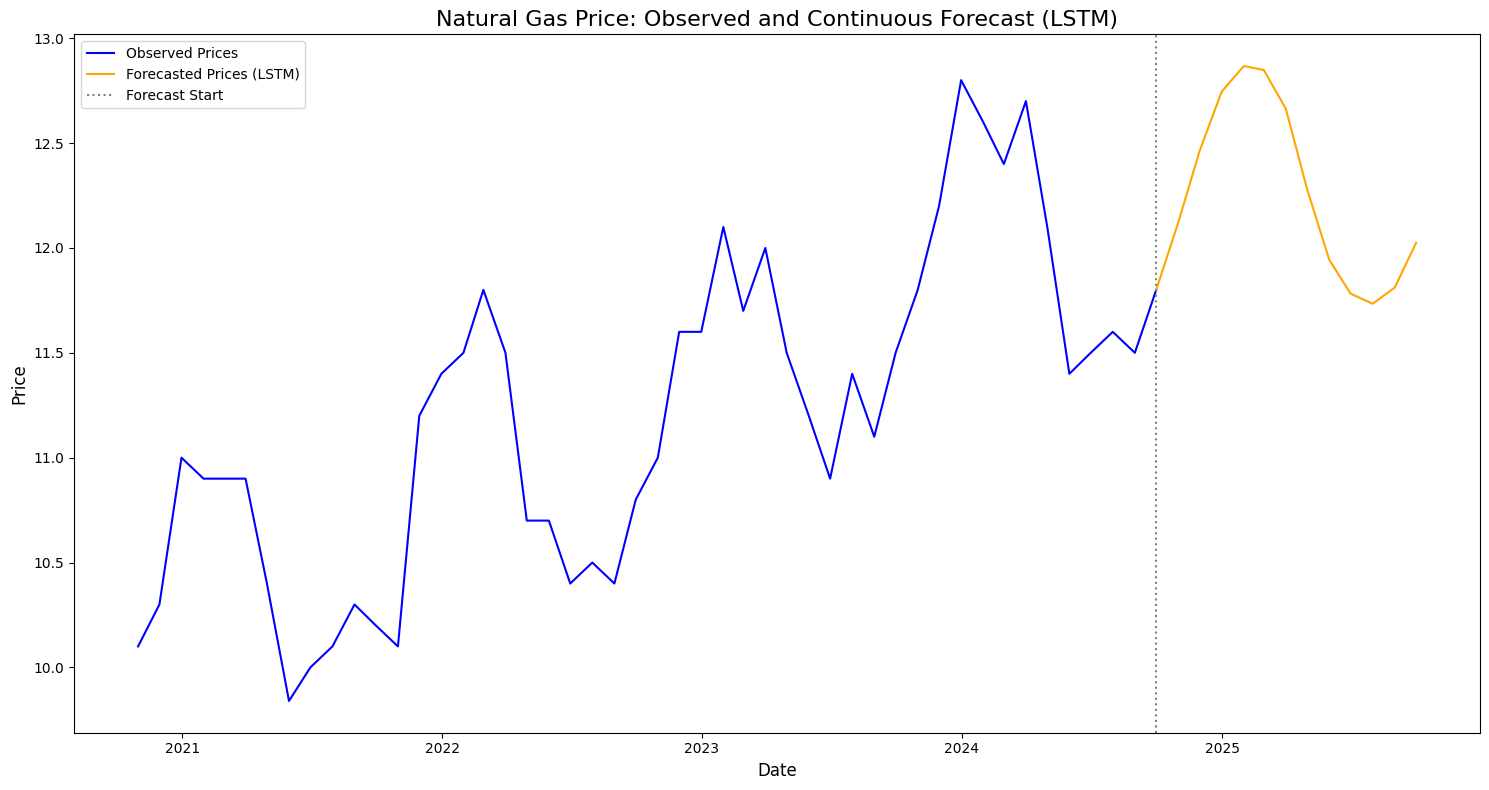

In [19]:

last_date = df.index[-1]
last_price = df['Prices'].iloc[-1]
last_point = pd.Series([last_price], index=[last_date])


continuous_forecast = pd.concat([last_point, forecast_series])

plt.figure(figsize=(15, 8))


plt.plot(df.index, df['Prices'], label='Observed Prices', color='blue')


plt.plot(continuous_forecast.index, continuous_forecast,
         label='Forecasted Prices (LSTM)', linestyle='-', color='orange')

plt.title('Natural Gas Price: Observed and Continuous Forecast (LSTM)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)


plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.legend() # Call legend to include all labels

plt.tight_layout()
plt.savefig('price_forecast_continuous_lstm.png')
print("\nSaved continuous forecast plot to 'price_forecast_continuous_lstm.png'")

In [14]:
full_series = pd.concat([df['Prices'], forecast_series])


numeric_dates = full_series.index.to_series().astype(np.int64)
numeric_values = full_series.values


price_interpolator = interp1d(
    numeric_dates,
    numeric_values,
    kind='linear',
    bounds_error=False,
    fill_value=np.nan
)


def get_price_estimate(date_str: str) -> float:
    """
    Estimates the price of natural gas for a given date.
    Uses linear interpolation for past dates and the 12-month
    LSTM forecast for future dates.
    """
    date_dt = pd.to_datetime(date_str)
    numeric_date = date_dt.value
    price = price_interpolator(numeric_date)
    return float(price)

print("\n'get_price_estimate' function created successfully.")


'get_price_estimate' function created successfully.


In [15]:
print("\nTesting the price estimation function:")


date_past_interp = "2021-06-15"
price_past_interp = get_price_estimate(date_past_interp)
print(f"Estimated price on {date_past_interp}: {price_past_interp:.2f}")


date_past_exact = "2022-03-31"
price_past_exact = get_price_estimate(date_past_exact)
print(f"Estimated price on {date_past_exact}: {price_past_exact:.2f} (Original: {df.loc[date_past_exact, 'Prices']:.2f})")


date_future = "2025-01-31"
price_future = get_price_estimate(date_future)
print(f"Estimated price on {date_future}: {price_future:.2f}")


date_oot = "2030-01-01"
price_oot = get_price_estimate(date_oot)
print(f"Estimated price on {date_oot}: {price_oot}")

print("\n--- Notebook execution complete ---")


Testing the price estimation function:
Estimated price on 2021-06-15: 9.92
Estimated price on 2022-03-31: 11.50 (Original: 11.50)
Estimated price on 2025-01-31: 12.87
Estimated price on 2030-01-01: nan

--- Notebook execution complete ---
